# 02 - Construção de Grafos de Xadrez

Este notebook implementa a construção de grafos a partir de posições de xadrez.

## Objetivos
1. Implementar diferentes tipos de grafos de xadrez
2. Visualizar estruturas de grafos
3. Analisar propriedades dos grafos
4. Preparar dados para GNNs

## Tipos de Grafos
- **Grafo de Ataque**: Arestas representam ataques entre peças
- **Grafo de Defesa**: Arestas representam defesas
- **Grafo de Movimento**: Arestas representam movimentos possíveis
- **Grafo Híbrido**: Combinação de múltiplas relações


In [17]:
# Importações necessárias
import sys
import os
sys.path.append('../src')

import chess
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import torch
from torch_geometric.data import Data
from typing import List, Dict, Tuple
import pickle
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Importar módulos do projeto
from data.chess_graph import ChessGraph, ChessGraphBuilder
from utils.visualization import GraphVisualizer
print("Módulos do projeto importados com sucesso!")

from data import ChessGraph


print("Bibliotecas importadas com sucesso!")
print(f"PyTorch version: {torch.__version__}")


# Carregar dados processados
def load_processed_data(filename='sample_chess_data.pkl'):
    """Carrega dados processados"""
    try:
        with open(f'../data/{filename}', 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Arquivo {filename} não encontrado. Execute primeiro o notebook 01_data_exploration.ipynb")
        return None

# Carregar dados
sample_data = load_processed_data()
if sample_data:
    print(f"Dados carregados: {len(sample_data['games'])} partidas")
else:
    print("Dados não encontrados. Criando dados de exemplo...")
    # Criar dados de exemplo
    sample_data = {
        'games': [],
        'positions': ['rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'],
        'moves': [],
        'ratings': [1500, 1600],
        'openings': ['Sicilian Defense'],
        'results': ['1-0']
    }


Módulos do projeto importados com sucesso!
Bibliotecas importadas com sucesso!
PyTorch version: 2.6.0+cpu-cxx11-abi
Dados carregados: 2704 partidas


In [18]:
# Testar implementação
print("Testando implementação das classes...")
test_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
# board = chess.Board(test_fen)
test_graph = ChessGraph(test_fen, "attack")
print(f"Grafo criado com {len(test_graph.nodes)} nós e {len(test_graph.edges)} arestas")

Testando implementação das classes...
Grafo criado com 32 nós e 0 arestas


In [19]:
MAX_POSITIONS=1500

In [20]:
# Construir grafos para posições de exemplo
def build_graphs_for_positions(positions, max_positions=5):
    """Constrói grafos para posições de exemplo"""
    graphs = {
        'attack': [],
        'defense': [],
        'movement': [],
        'hybrid': []
    }
    
    print(f"Construindo grafos para {min(len(positions), max_positions)} posições...")
    
    for i, fen in enumerate(positions[:max_positions]):
        print(f"Processando posição {i+1}/{min(len(positions), max_positions)}")
        
        # Construir diferentes tipos de grafos
        for graph_type in ['attack', 'defense', 'movement', 'hybrid']:
            try:
                graph = ChessGraph(fen, graph_type)
                graphs[graph_type].append(graph)
                print(f"  {graph_type}: {len(graph.nodes)} nós, {len(graph.edges)} arestas")
            except Exception as e:
                print(f"  Erro ao construir grafo {graph_type}: {e}")
    
    return graphs

# Construir grafos
if sample_data and sample_data['positions']:
    chess_graphs = build_graphs_for_positions(sample_data['positions'], max_positions=MAX_POSITIONS)
else:
    # Usar posição de exemplo
    example_positions = [
        "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1",
        "rnbqkbnr/pppp1ppp/8/2pp4/4P3/8/PPPP1PPP/RNBQKBNR w KQkq d6 0 2"
    ]
    chess_graphs = build_graphs_for_positions(example_positions)

print(f"\nGrafos construídos:")
for graph_type, graphs in chess_graphs.items():
    print(f"  {graph_type}: {len(graphs)} grafos")

Construindo grafos para 1500 posições...
Processando posição 1/1500
  attack: 32 nós, 0 arestas
  defense: 32 nós, 0 arestas
  movement: 64 nós, 20 arestas
  hybrid: 32 nós, 20 arestas
Processando posição 2/1500
  attack: 22 nós, 4 arestas
  defense: 22 nós, 0 arestas
  movement: 64 nós, 35 arestas
  hybrid: 22 nós, 39 arestas
Processando posição 3/1500
  attack: 11 nós, 0 arestas
  defense: 11 nós, 0 arestas
  movement: 64 nós, 13 arestas
  hybrid: 11 nós, 13 arestas
Processando posição 4/1500
  attack: 32 nós, 0 arestas
  defense: 32 nós, 0 arestas
  movement: 64 nós, 20 arestas
  hybrid: 32 nós, 20 arestas
Processando posição 5/1500
  attack: 22 nós, 0 arestas
  defense: 22 nós, 0 arestas
  movement: 64 nós, 33 arestas
  hybrid: 22 nós, 33 arestas
Processando posição 6/1500
  attack: 15 nós, 2 arestas
  defense: 15 nós, 0 arestas
  movement: 64 nós, 45 arestas
  hybrid: 15 nós, 47 arestas
Processando posição 7/1500
  attack: 32 nós, 0 arestas
  defense: 32 nós, 0 arestas
  movement:

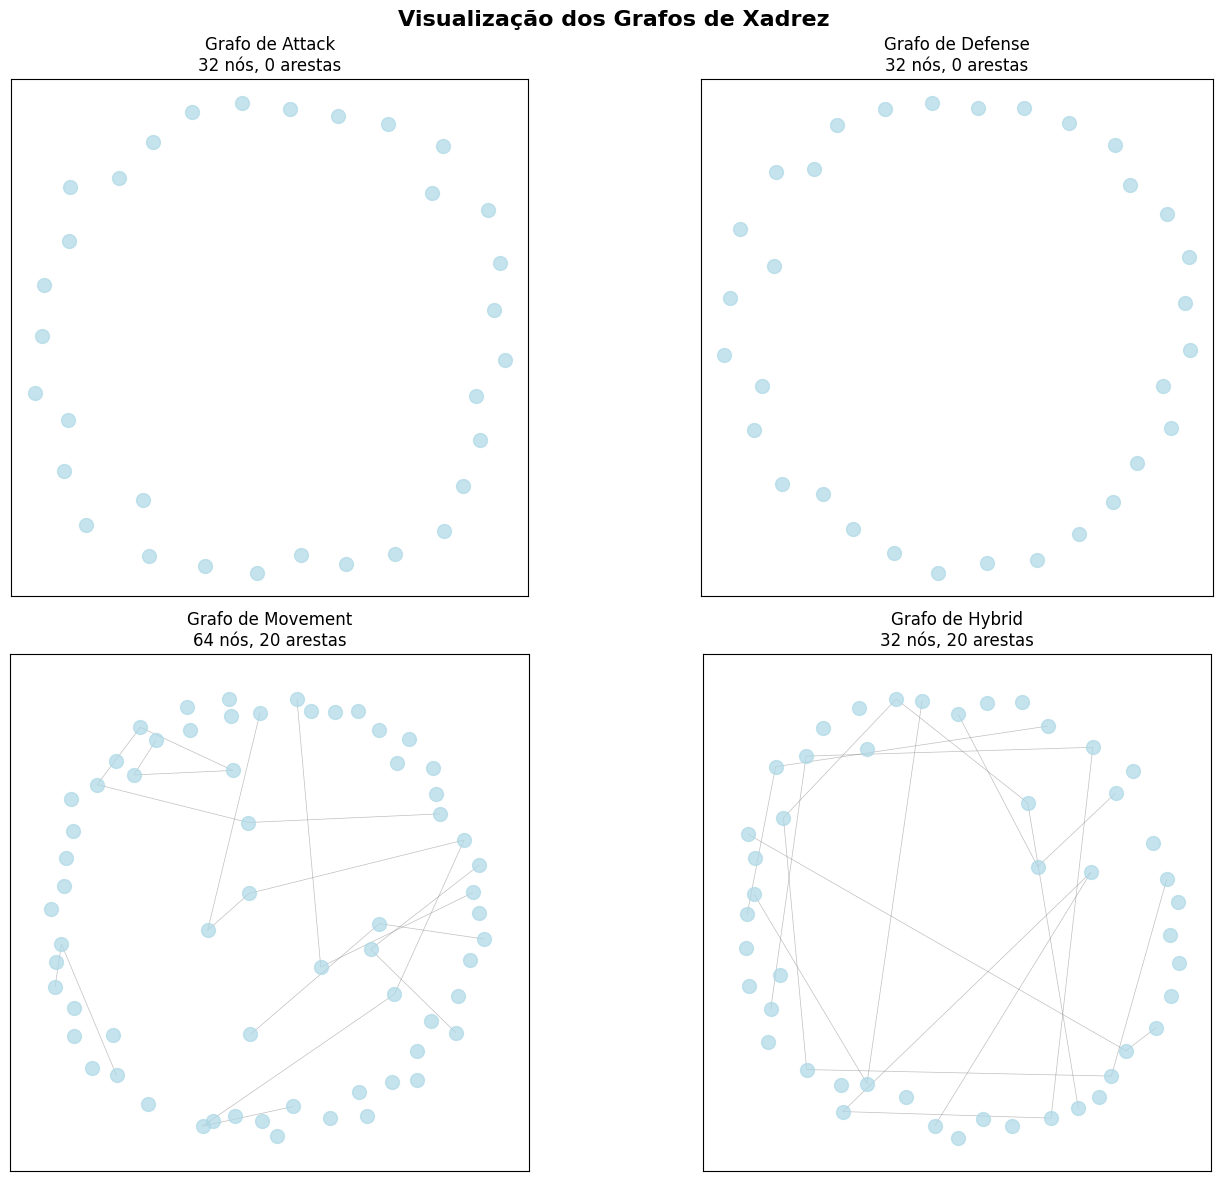

In [22]:
# Visualização dos grafos construídos
def visualize_chess_graphs(graphs, max_graphs=15):
    """Visualiza os grafos construídos"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Visualização dos Grafos de Xadrez', fontsize=16, fontweight='bold')
    
    graph_types = ['attack', 'defense', 'movement', 'hybrid']
    
    for idx, graph_type in enumerate(graph_types):
        ax = axes[idx // 2, idx % 2]
        
        if graphs[graph_type]:
            # Usar o primeiro grafo disponível
            graph = graphs[graph_type][0]
            
            # Converter para NetworkX
            nx_graph = graph.to_networkx()
            
            # Layout do grafo
            pos = nx.spring_layout(nx_graph, k=1, iterations=50)
            
            # Desenhar nós
            nx.draw_networkx_nodes(nx_graph, pos, ax=ax, 
                                 node_color='lightblue', 
                                 node_size=100, alpha=0.7)
            
            # Desenhar arestas
            nx.draw_networkx_edges(nx_graph, pos, ax=ax, 
                                 edge_color='gray', 
                                 alpha=0.5, width=0.5)
            
            # Adicionar labels dos nós (apenas alguns para não poluir)
            if len(nx_graph.nodes()) <= 20:
                labels = {node: chess.square_name(node) if isinstance(node, int) else str(node) 
                         for node in nx_graph.nodes()}
                nx.draw_networkx_labels(nx_graph, pos, labels, ax=ax, font_size=8)
            
            ax.set_title(f'Grafo de {graph_type.title()}\n{len(graph.nodes)} nós, {len(graph.edges)} arestas')
            ax.set_aspect('equal')
        else:
            ax.text(0.5, 0.5, f'Nenhum grafo {graph_type} disponível', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Grafo de {graph_type.title()}')
    
    plt.tight_layout()
    plt.show()

# Visualizar grafos
visualize_chess_graphs(chess_graphs)


In [23]:
# Análise das propriedades dos grafos
def analyze_graph_properties(graphs):
    """Analisa propriedades dos grafos construídos"""
    
    print("=== ANÁLISE DAS PROPRIEDADES DOS GRAFOS ===")
    
    for graph_type, graph_list in graphs.items():
        if not graph_list:
            continue
            
        print(f"\n📊 GRAFOS DE {graph_type.upper()}:")
        
        # Estatísticas básicas
        num_nodes = [len(g.nodes) for g in graph_list]
        num_edges = [len(g.edges) for g in graph_list]
        
        print(f"  Nós - Média: {np.mean(num_nodes):.1f}, Min: {min(num_nodes)}, Max: {max(num_nodes)}")
        print(f"  Arestas - Média: {np.mean(num_edges):.1f}, Min: {min(num_edges)}, Max: {max(num_edges)}")
        
        # Densidade
        densities = []
        for graph in graph_list:
            if len(graph.nodes) > 1:
                max_edges = len(graph.nodes) * (len(graph.nodes) - 1) / 2
                density = len(graph.edges) / max_edges if max_edges > 0 else 0
                densities.append(density)
        
        if densities:
            print(f"  Densidade - Média: {np.mean(densities):.3f}, Min: {min(densities):.3f}, Max: {max(densities):.3f}")
        
        # Análise de conectividade
        connectivity_stats = []
        for graph in graph_list:
            nx_graph = graph.to_networkx()
            if len(nx_graph.nodes()) > 0:
                # Número de componentes conectados
                num_components = nx.number_connected_components(nx_graph)
                connectivity_stats.append(num_components)
        
        if connectivity_stats:
            print(f"  Componentes - Média: {np.mean(connectivity_stats):.1f}, Min: {min(connectivity_stats)}, Max: {max(connectivity_stats)}")

# Analisar propriedades
analyze_graph_properties(chess_graphs)


=== ANÁLISE DAS PROPRIEDADES DOS GRAFOS ===

📊 GRAFOS DE ATTACK:
  Nós - Média: 24.0, Min: 2, Max: 32
  Arestas - Média: 1.0, Min: 0, Max: 9
  Densidade - Média: 0.005, Min: 0.000, Max: 0.167
  Componentes - Média: 23.0, Min: 2, Max: 32

📊 GRAFOS DE DEFENSE:
  Nós - Média: 24.0, Min: 2, Max: 32
  Arestas - Média: 0.1, Min: 0, Max: 2
  Densidade - Média: 0.000, Min: 0.000, Max: 0.010
  Componentes - Média: 23.9, Min: 2, Max: 32

📊 GRAFOS DE MOVEMENT:
  Nós - Média: 64.0, Min: 64, Max: 64
  Arestas - Média: 21.9, Min: 0, Max: 57
  Densidade - Média: 0.011, Min: 0.000, Max: 0.028
  Componentes - Média: 43.7, Min: 15, Max: 64

📊 GRAFOS DE HYBRID:
  Nós - Média: 24.0, Min: 2, Max: 32
  Arestas - Média: 23.0, Min: 0, Max: 60
  Densidade - Média: 0.137, Min: 0.000, Max: 8.000
  Componentes - Média: 19.1, Min: 2, Max: 30


In [24]:
# Salvar grafos construídos
def save_constructed_graphs(graphs, filename='constructed_graphs.pkl'):
    """Salva grafos construídos para uso posterior"""
    output_path = f'../data/{filename}'
    
    # Criar diretório se não existir
    os.makedirs('../data', exist_ok=True)
    
    # Salvar grafos
    with open(output_path, 'wb') as f:
        pickle.dump(graphs, f)
    
    print(f"Grafos salvos em: {output_path}")
    print(f"Tamanho do arquivo: {os.path.getsize(output_path) / (1024**2):.2f} MB")

# Salvar grafos
save_constructed_graphs(chess_graphs)

print("\n✅ Grafos construídos e salvos com sucesso!")
print("📁 Arquivos criados:")
print("  - ../data/constructed_graphs.pkl")
print("\n🎯 Próximos passos:")
print("  - Execute o notebook 03_graph_analysis.ipynb para análise detalhada")
print("  - Execute o notebook 04_gnn_implementation.ipynb para implementar GNNs")


Grafos salvos em: ../data/constructed_graphs.pkl
Tamanho do arquivo: 24.72 MB

✅ Grafos construídos e salvos com sucesso!
📁 Arquivos criados:
  - ../data/constructed_graphs.pkl

🎯 Próximos passos:
  - Execute o notebook 03_graph_analysis.ipynb para análise detalhada
  - Execute o notebook 04_gnn_implementation.ipynb para implementar GNNs
